In [34]:
import csv
import random
import numpy
import pandas as pd
import math
import time
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
def allDone():
    urL = 'http://www.wavsource.com/snds_2018-06-03_5106726768923853/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))
    
motifs = (numpy.genfromtxt('data/new/new_motifs.csv',dtype='U',delimiter='µ'))
fams = (numpy.genfromtxt('data/new/new_fams.csv',dtype='U'))
motifxFamMatrix = numpy.genfromtxt('data/new/new_motifxFamMatrix.csv',delimiter=',',dtype=int)

print(motifs.shape)
print(motifs[47], fams[numpy.argmax(motifxFamMatrix[47])])
print(fams.shape)
print(motifxFamMatrix.shape)

all_characters = []
for motif in motifs:
    for c in motif:
        all_characters.append(c)
amino_acids = ''.join(list(set(all_characters)))
amino_acids = '_' + (amino_acids)
n_letters = (len(set(amino_acids)))
vocab_size = len(amino_acids)

print(amino_acids)
print(n_letters, vocab_size)

max_len = (max( [len(x) for x in motifs] ))
for mIdx, motif in enumerate(motifs):
    length = len(motif)
    buffer_length = max_len - length
    buff_motif = motif + "_" * buffer_length
    motifs[mIdx] = buff_motif

(10087,)
LEELRRLSWSGIPKP STE20
(133,)
(10087, 133)
_NILPGSQYVARFDEKCTHWM
21 21


In [3]:
num_x_per_label = numpy.sum(motifxFamMatrix, axis=0)
print(numpy.max(num_x_per_label))
max_ids = numpy.argpartition(num_x_per_label, -10)[-10:]
num_top_10 = numpy.sum(num_x_per_label[max_ids])
print(numpy.min(num_x_per_label[max_ids]))
print(num_top_10 / len(motifs))
print(numpy.count_nonzero(num_x_per_label < 50))

bottom_ids = numpy.where(num_x_per_label < 50)
num_bottom = numpy.sum(num_x_per_label[bottom_ids])
print(num_bottom / len(motifs))

1267
467
0.739764052741152
63
0.11063745414890452


In [4]:
SEED = 0
EPOCHS = 40
BATCH_SIZE = 128
LEARNING_RATE = 0.005
ENCODER_LAYER_SIZES = [315, 200, 100]  # 15*21=315
DECODER_LAYER_SIZES = [100, 200, 315]
LATENT_SIZE = 20
PRINT_EVERY = 100
FIG_ROOT = 'cvae_figs'
CONDITIONAL = True
ONE_HOT_LABEL_SIZE = len(fams) if CONDITIONAL else 0
KL_MAX_WEIGHT = .25

x1 = numpy.linspace(numpy.pi, 2*numpy.pi, 4000, endpoint=True)
kl_w = ((numpy.cos(x1)+1)/2) * KL_MAX_WEIGHT
kl_w = numpy.hstack((numpy.zeros(2000), kl_w))
print(kl_w.shape, kl_w)

(6000,) [0.         0.         0.         ... 0.24999985 0.24999996 0.25      ]


In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return amino_acids.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
#     print (n_letters)
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [6]:
trainSetSize = int( len(motifs) * .5)
temp_trainIdc = random.sample(range (len(motifs)), trainSetSize)

valSetSize = int( trainSetSize * .5 )
valIdc = random.sample(temp_trainIdc, valSetSize)
trainIdc = [i for i in temp_trainIdc if i not in valIdc]

testIdc = [i for i in range(len(motifs)) if i not in temp_trainIdc]


print (len(trainIdc))
print (len(valIdc))
print (len(testIdc))

random.seed(46)
random.shuffle(trainIdc)
random.seed(46)
random.shuffle(valIdc)
random.seed(46)
random.shuffle(testIdc)

2522
2521
5044


In [7]:
# idc: set of indicies to get batch from
def getBatch(idc):
    
    mIdx_batch = []  # one hot embedding of motif characters [15 x 128 x 21]
    target_batch = []  # character indicies for motifs [15 x 128]
    num_of_samps_in_batch = 0
    mIdc = []  # motif indices for batch [128]
    label_batch = numpy.empty((BATCH_SIZE, len(fams))) # one hot label embedding for motifs [128 x 133]

    while num_of_samps_in_batch < BATCH_SIZE:
        num_of_samps_in_batch += 1

        mIdx = random.choice(idc)  # pick random index from set
        motif = motifs[mIdx]
        motif_tensor = lineToTensor(motif)
        label_batch[num_of_samps_in_batch-1] = motifxFamMatrix[mIdx]

        mIdx_batch.append(motif_tensor)
        
        motif_idc = [letterToIndex(aa) for aa in motif]
        motif_idc = torch.tensor(motif_idc)
        target_batch.append(motif_idc)
        mIdc.append(mIdx)

    mIdx_batch = torch.nn.utils.rnn.pad_sequence(mIdx_batch, batch_first=False)
    mIdx_batch = mIdx_batch.squeeze(-2)

    maxLen = mIdx_batch.shape[0]
    
    target_batch = torch.nn.utils.rnn.pad_sequence(target_batch, batch_first=False).squeeze(-1)
    
    return (mIdx_batch, maxLen, target_batch, mIdc, torch.from_numpy(label_batch).float())

In [8]:
def loss_fn(recon_x, x, mu, cov, w2=1):
    recon_x = recon_x.view(-1, vocab_size)  
    x = x.view(-1)
    
#     print (x.shape)
    
#     print(recon_x.shape, recon_x)
#     print(x.shape, x)
    criterion = nn.CrossEntropyLoss()
    CCE = criterion(recon_x, x)

#     KLD = -0.5 * torch.sum(1 + cov - mu.pow(2) - cov.exp())
    KLD = (-0.5 * torch.sum(cov - torch.pow(mu, 2) - torch.exp(cov) + 1, 1)).mean().squeeze()

#     return CCE
    return CCE + w2*KLD, CCE, KLD

def max_loss_fn(recon_x, x, mu, cov, w2=1):
#     print('recon_x.shape:', recon_x.shape)
#     print('x.shape:', x.shape)
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x.view(-1, 15*21), x.view(-1, 15*21), reduction='sum'
        )
    KLD = -0.5 * torch.sum(1 + cov - mu.pow(2) - cov.exp())

#     return BCE
    return (BCE + w2*KLD) / x.size(0), BCE, KLD

In [9]:
class VAE(nn.Module):

    def __init__(self, latent_size):
        super(VAE, self).__init__()

#         assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
#         assert type(decoder_layer_sizes) == list

        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)

    def forward(self, x, c=None):
        means, log_var = self.encoder(x, c)

        # reparameterization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn([BATCH_SIZE, LATENT_SIZE])
        z = eps * std + means

        recon_x = self.decoder(z, BATCH_SIZE, c)

        return recon_x, means, log_var, z

    def inference(self, n=1, c=None):
        z = torch.randn([n, LATENT_SIZE])

        recon_x = self.decoder(z, n, c)

        return recon_x
    
    def embed(self, x, c=None):
        means, log_var = self.encoder(x, c)
        
        # reparameterization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn([BATCH_SIZE, LATENT_SIZE])
        z = eps * std + means
        
        return z 


class Encoder(nn.Module):

    def __init__(self, latent_size):
        super().__init__()
        
        self.fc1 = nn.Linear(ENCODER_LAYER_SIZES[0] + ONE_HOT_LABEL_SIZE, ENCODER_LAYER_SIZES[1])
        self.bn = nn.BatchNorm1d(max_len)
        self.fc2 = nn.Linear(ENCODER_LAYER_SIZES[1], ENCODER_LAYER_SIZES[2])

        self.mu = nn.Linear(ENCODER_LAYER_SIZES[2], latent_size)
        self.log_var = nn.Linear(ENCODER_LAYER_SIZES[2], latent_size)

    def forward(self, x, c=None):
        x = x.view(BATCH_SIZE, -1)
#         print(x.shape)
        if CONDITIONAL:
#             c = idx2onehot(c, n=10)
            x = torch.cat((x, c), dim=-1)
#         print(x.shape)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)

        mus = self.mu(x)
        log_vars = self.log_var(x)

        return mus, log_vars


class Decoder(nn.Module):

    def __init__(self, latent_size):
        super().__init__()
        
        self.fc1 = nn.Linear(latent_size + ONE_HOT_LABEL_SIZE, DECODER_LAYER_SIZES[0])
        self.fc2 = nn.Linear(DECODER_LAYER_SIZES[0], DECODER_LAYER_SIZES[1])
        self.fc3 = nn.Linear(DECODER_LAYER_SIZES[1], DECODER_LAYER_SIZES[2])

    def forward(self, z, n, c=None):

        if CONDITIONAL:
#             print(z.shape)
            z = torch.cat((z, c), dim=-1)

        x = self.fc1(z)
#         x = F.relu(x)
        x = self.fc2(x)
#         x = F.relu(x)
        x = self.fc3(x)
#         print('x.shape1:',x.shape)
        x = torch.sigmoid(x)
#         print('x.shape2:',x.shape)
        x = x.view(15, n, 21)
#         print('x.shape3:',x.shape)
        return x

In [10]:
# model = VAE(embedding_dim = 100, hidden_dim = 25,
#                        vocab_size = len(amino_acids), latent_variable_size = LATENT_DIM)  #5 # was len(fams)

model = VAE(LATENT_SIZE)
print(model)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=448, out_features=200, bias=True)
    (bn): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=200, out_features=100, bias=True)
    (mu): Linear(in_features=100, out_features=20, bias=True)
    (log_var): Linear(in_features=100, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=153, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=200, bias=True)
    (fc3): Linear(in_features=200, out_features=315, bias=True)
  )
)


In [11]:
name_guess_samples = []

# criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.Adadelta(model.parameters(),lr = 0.01 )

# optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

loss_history = []
bce_loss_history = []
kl_loss_history = []
acc_history = []
val_loss_history = []

z_mu_history = []
z_std_history = []

s = 1
kl_w_i = 0
for epoch in range(EPOCHS):
    tot_loss = []
    tot_kl_loss = []
    tot_bce_loss = []
    
    bIdx = 0
    while bIdx < 250: #250: #range(())):len(trainIdc) len(motifs) 
        optimizer.zero_grad()
        bIdx+=1
        
#         print('trainIdc:', len(trainIdc), trainIdc)
        mIdx_batch, maxLen, target_batch, mIdc, label_batch = getBatch(trainIdc)
#         print('mIdx_batch:', mIdx_batch.shape)
#         print('maxLen:', maxLen)
#         print('target_batch:', target_batch.shape, target_batch[: 0], target_batch.view(-1))
#         print('mIdc:', len(mIdc))
#         print('label_batch:', label_batch.shape
#         print('label_batch:', label_batch.shape, label_batch)
#         output, z, mu, cov = model(mIdx_batch, c=label_batch)
        output, mu, cov, z = model(mIdx_batch, c=label_batch)

#         print('output:', output.shape)
#         print('mIdx_batch:', mIdx_batch.shape)
#         print('target_batch:', target_batch.shape)
        
        # LOSS FUNCTION 
#         loss, bce_term, kl_term = loss_fn(output, target_batch, mu, cov, w2=kl_w[kl_w_i])
        loss, bce_term, kl_term = max_loss_fn(output, mIdx_batch, mu, cov, w2=kl_w[kl_w_i])
        tot_loss.append(loss)
        tot_kl_loss.append(kl_term)
        tot_bce_loss.append(bce_term)
        loss.backward()
        optimizer.step()
        
        if bIdx % 25 == 0 :
            print("Iter {}\nEpoch number {}\nCurrent loss {}, kl_w {}".format(s,epoch+1, sum(tot_loss)/len(tot_loss), kl_w[kl_w_i]))
            loss_history.append( sum(tot_loss)/len(tot_loss) )
            kl_loss_history.append( sum(tot_kl_loss)/len(tot_kl_loss) )
            bce_loss_history.append( sum(tot_bce_loss)/len(tot_bce_loss) )

            # ------ ACCURACY -----
            mIdx_batch, maxLen, fam_batch, acc_mIdc, label_batch = getBatch(trainIdc)
#             output, z, mu, cov = model(mIdx_batch, c=label_batch)
            output, mu, cov, z = model(mIdx_batch, c=label_batch)
            
            z_np = z.detach().numpy()
            z_mu_all = numpy.mean(z_np)
            z_std_all = numpy.std(z_np)
            print('Train z (mean, std dev): ({}, {})'.format(z_mu_all, z_std_all))
            z_mu_history.append(z_mu_all)
            z_std_history.append(z_std_all)
            
            scores = []
            
            output = output.transpose(0,1)
            mIdx_batch = mIdx_batch.transpose(0,1)
#             print(output.shape)
            for i, samp_res in enumerate(output):
#                 print('hi')
                length = sum([ 1 for l in motifs[ acc_mIdc[i] ] if l != '_' ])
                pred = samp_res.argmax(1).detach().numpy()
                true = mIdx_batch[i].argmax(1).detach().numpy()
#                 print (samp_res.shape,pred,true)
                score = numpy.sum([1 for j in range(length) if (true[j]==pred[j] and true[j] != 0)])
                score /= length
                scores.append( score )
                if i==10:  # check 10th item in batch
                    true_name = motifs[ acc_mIdc[i] ]
                    pred_name = ''.join([amino_acids[j] for j in pred])
                    
                    print (pred_name, "|",true_name,  numpy.sum([1 for j in range(length) if (true[j]==pred[j] and true[j] != 0)])/length )
                    name_guess_samples.append([pred_name,true_name])

#             print (scores)
            accuracy = sum(scores) / BATCH_SIZE
            acc_history.append(accuracy)
            
            # ------ VALIDATION LOSS -----
            mIdx_batch, maxLen, target_batch, mIdc, label_batch = getBatch(valIdc)
#             output, z, mu, cov = model(mIdx_batch, c=label_batch)
            output, mu, cov, z = model(mIdx_batch, c=label_batch)

            
#             val_loss, _, _ = loss_fn(output, target_batch, mu, cov, w2=kl_w[kl_w_i])
            val_loss, _, _ = max_loss_fn(output, mIdx_batch, mu, cov, w2=kl_w[kl_w_i])
            val_loss_history.append(val_loss)
            
            print("Train Accuracy:",accuracy)
            print("Val loss: {}\n".format(val_loss))
            
        s+=1
        if kl_w_i < len(kl_w)-1:
            kl_w_i += 1
    

Iter 25
Epoch number 1
Current loss 773.958984375, kl_w 0.0
Train z (mean, std dev): (-0.03493710607290268, 0.7856884002685547)
SSSSSSSSSSSSSSS | SPLVGVTSTPGTGQS 0.2
Train Accuracy: 0.13385416666666655
Val loss: 496.6030578613281

Iter 50
Epoch number 1
Current loss 634.0674438476562, kl_w 0.0
Train z (mean, std dev): (-0.0433187335729599, 0.6714463829994202)
SSSSSSSSSSSSSSS | DGPRSPSYGRSRSRS 0.3333333333333333
Train Accuracy: 0.1442708333333332
Val loss: 485.3124084472656

Iter 75
Epoch number 1
Current loss 584.71923828125, kl_w 0.0
Train z (mean, std dev): (-0.07907678186893463, 0.6400641202926636)
SSSSSSSSSSSSSSS | AMQSNSPSQEQQQQQ 0.2
Train Accuracy: 0.1411458333333332
Val loss: 481.1145935058594

Iter 100
Epoch number 1
Current loss 559.0850219726562, kl_w 0.0
Train z (mean, std dev): (-0.09911887347698212, 0.8031982779502869)
SSSSSSSSSSSSSSS | VEAEAGGSGARTPPL 0.06666666666666667
Train Accuracy: 0.12395833333333324
Val loss: 473.8094177246094

Iter 125
Epoch number 1
Current loss 

Train Accuracy: 0.30364583333333306
Val loss: 416.58892822265625

Iter 875
Epoch number 4
Current loss 415.8300476074219, kl_w 0.0
Train z (mean, std dev): (-0.18524807691574097, 1.1432005167007446)
GGLSSEYSPLTSPTP | VELFGPISLEQVRFP 0.2
Train Accuracy: 0.3093749999999998
Val loss: 412.4253845214844

Iter 900
Epoch number 4
Current loss 414.43316650390625, kl_w 0.0
Train z (mean, std dev): (-0.18305657804012299, 1.2104907035827637)
SLSPRVYSLEPGPAK | SSSEDAESLAPRSKV 0.3333333333333333
Train Accuracy: 0.3057291666666665
Val loss: 406.79547119140625

Iter 925
Epoch number 4
Current loss 413.36920166015625, kl_w 0.0
Train z (mean, std dev): (-0.16414226591587067, 1.2240396738052368)
PLRLSSRSAVPTPTE | KRAGGANSNVFSMFE 0.2
Train Accuracy: 0.32343749999999977
Val loss: 405.7695617675781

Iter 950
Epoch number 4
Current loss 412.5834045410156, kl_w 0.0
Train z (mean, std dev): (-0.1750655472278595, 1.2131296396255493)
SATSGSRSPSPSEEP | AQLAGSDSDLDSDDE 0.26666666666666666
Train Accuracy: 0.320833

Train Accuracy: 0.42812499999999987
Val loss: 349.68841552734375

Iter 1725
Epoch number 7
Current loss 360.2000732421875, kl_w 0.0
Train z (mean, std dev): (-0.12817160785198212, 1.5162460803985596)
KFRLPKPSSPEKLPK | VQGVPLESSNNDIFL 0.2
Train Accuracy: 0.41666666666666674
Val loss: 352.0357971191406

Iter 1750
Epoch number 7
Current loss 359.6120300292969, kl_w 0.0
Train z (mean, std dev): (-0.1681338995695114, 1.529343605041504)
ERYAPPSTPSRADGD | FRYIPPNTPENFWEV 0.4
Train Accuracy: 0.41250000000000003
Val loss: 353.6944885253906

Iter 1775
Epoch number 8
Current loss 350.7841491699219, kl_w 0.0
Train z (mean, std dev): (-0.1356041133403778, 1.5617334842681885)
TEDVPQLTDRAQKLL | TNQNTGMTLPAQKCI 0.3333333333333333
Train Accuracy: 0.41510416666666666
Val loss: 353.92755126953125

Iter 1800
Epoch number 8
Current loss 350.8666076660156, kl_w 0.0
Train z (mean, std dev): (-0.15527591109275818, 1.4662199020385742)
RKTARELTAVDLTRG | RHTDDEMTGYVATRW 0.4
Train Accuracy: 0.42083333333333345
Va

Train Accuracy: 0.48541666666666683
Val loss: 339.23748779296875

Iter 2525
Epoch number 11
Current loss 338.7447509765625, kl_w 0.010442343887505562
Train z (mean, std dev): (-0.011581568978726864, 1.4644930362701416)
NGTPKRPSRAQDKKG | DVTPLRFSRIHDGEA 0.4
Train Accuracy: 0.45989583333333334
Val loss: 342.6014099121094

Iter 2550
Epoch number 11
Current loss 339.66241455078125, kl_w 0.011446670145413285
Train z (mean, std dev): (-0.09630833566188812, 1.446684718132019)
SSKLSRPSPESSGRK | DIKGSYVSIHSSGFR 0.4
Train Accuracy: 0.45885416666666673
Val loss: 345.5849914550781

Iter 2575
Epoch number 11
Current loss 340.27313232421875, kl_w 0.012494795269558615
Train z (mean, std dev): (-0.12250179052352905, 1.420143961906433)
NSLDSVESALEESDT | DSLLSALSLNEESLG 0.4666666666666667
Train Accuracy: 0.46718749999999976
Val loss: 340.2652587890625

Iter 2600
Epoch number 11
Current loss 340.0632019042969, kl_w 0.013586314985648815
Train z (mean, std dev): (-0.04798733443021774, 1.4178478717803955)
D

Iter 3300
Epoch number 14
Current loss 350.66912841796875, kl_w 0.059631171733759106
Train z (mean, std dev): (-0.038966041058301926, 1.1016030311584473)
LGAEATPSLRKGESA | LVAEAIHSGKKKEAM 0.4666666666666667
Train Accuracy: 0.4635416666666667
Val loss: 345.3355712890625

Iter 3325
Epoch number 14
Current loss 350.3251953125, kl_w 0.06173618059989426
Train z (mean, std dev): (-0.011445758864283562, 1.1123085021972656)
LKGSASAYFRGQEPR | LRGQEHKYLLGDAPV 0.3333333333333333
Train Accuracy: 0.4572916666666666
Val loss: 350.4073791503906

Iter 3350
Epoch number 14
Current loss 351.05157470703125, kl_w 0.06386559107157574
Train z (mean, std dev): (-0.05905791372060776, 1.0918350219726562)
SLTPAAPSPGPGPSK | SITPAVKSPLPGPSE 0.6666666666666666
Train Accuracy: 0.4583333333333334
Val loss: 356.810546875

Iter 3375
Epoch number 14
Current loss 351.2751770019531, kl_w 0.06601858180992665
Train z (mean, std dev): (-0.014394648373126984, 1.1103062629699707)
AKATERPSSERPSSR | AELEKKLSSERPSSD 0.5333333333

Iter 4075
Epoch number 17
Current loss 372.3678894042969, kl_w 0.1323116734732587
Train z (mean, std dev): (0.006093212403357029, 1.0120786428451538)
QRKLRGTSPPLGESK | NKDVTLTSPLLVNLL 0.26666666666666666
Train Accuracy: 0.45520833333333344
Val loss: 370.0316467285156

Iter 4100
Epoch number 17
Current loss 372.7899475097656, kl_w 0.13476088539708958
Train z (mean, std dev): (-0.03289441391825676, 1.0102213621139526)
SLRRRLPTESQPPLS | QFRRRAHTFSHPPSS 0.5333333333333333
Train Accuracy: 0.44895833333333346
Val loss: 369.00396728515625

Iter 4125
Epoch number 17
Current loss 373.158447265625, kl_w 0.13720633243164393
Train z (mean, std dev): (-0.01270875334739685, 1.0266815423965454)
KPTPGLLSSVRPTDS | KPQKRVPSSRRLGLS 0.4
Train Accuracy: 0.47291666666666665
Val loss: 372.18426513671875

Iter 4150
Epoch number 17
Current loss 373.4407653808594, kl_w 0.139647071338994
Train z (mean, std dev): (-0.046846576035022736, 0.9960582852363586)
RLDSRLLYLLVTKGE | RVDSDNAYIGVTYKN 0.4
Train Accuracy: 0.4

Iter 4850
Epoch number 20
Current loss 391.810791015625, kl_w 0.20236457038331102
Train z (mean, std dev): (-0.040701478719711304, 1.010113000869751)
SSRPLSLSVPDKRRL | SSGSDSDSEVDKKLK 0.4
Train Accuracy: 0.4604166666666666
Val loss: 390.3639831542969

Iter 4875
Epoch number 20
Current loss 391.9482116699219, kl_w 0.20427780915033122
Train z (mean, std dev): (-0.010937362909317017, 0.9969847798347473)
RSQTLATSPDPAKGR | RSINKLDSPDPFKLN 0.4666666666666667
Train Accuracy: 0.46770833333333334
Val loss: 398.5265197753906

Iter 4900
Epoch number 20
Current loss 392.11798095703125, kl_w 0.2061604695260085
Train z (mean, std dev): (0.00772607559338212, 1.0226103067398071)
TPKPERSSGRPASAA | TPKPLRSSADPALNQ 0.6
Train Accuracy: 0.47291666666666654
Val loss: 393.25372314453125

Iter 4925
Epoch number 20
Current loss 392.18450927734375, kl_w 0.2080118253459049
Train z (mean, std dev): (-0.013984518125653267, 1.0037598609924316)
AGILAPESSLPTPRE | AVCADPCSLIPTPDK 0.4
Train Accuracy: 0.4666666666666667

Train Accuracy: 0.4505208333333334
Val loss: 404.2375183105469

Iter 5650
Epoch number 23
Current loss 401.729248046875, kl_w 0.24530457193655453
Train z (mean, std dev): (0.02982136234641075, 0.9935835003852844)
TTGSRGRSEPLTTGP | THLSRVRSLDLDDWP 0.4666666666666667
Train Accuracy: 0.44947916666666654
Val loss: 397.8753967285156

Iter 5675
Epoch number 23
Current loss 401.9225769042969, kl_w 0.24594787174542088
Train z (mean, std dev): (-0.0003925740602426231, 1.0122119188308716)
TEDPTLRSPRVTPEG | TYMDQAPSPAVCPQA 0.3333333333333333
Train Accuracy: 0.4661458333333333
Val loss: 404.3857727050781

Iter 5700
Epoch number 23
Current loss 402.0902404785156, kl_w 0.24654452052553205
Train z (mean, std dev): (0.04295242577791214, 0.9926007986068726)
ETKTERTSTSLKAEL | EKKTKIRSLHNKLLN 0.3333333333333333
Train Accuracy: 0.4671875000000001
Val loss: 408.3788757324219

Iter 5725
Epoch number 23
Current loss 402.12347412109375, kl_w 0.24709428814237624
Train z (mean, std dev): (-0.06218224763870239, 

Train Accuracy: 0.46145833333333336
Val loss: 406.0263366699219

Iter 6450
Epoch number 26
Current loss 402.3681335449219, kl_w 0.25
Train z (mean, std dev): (0.0286647230386734, 1.0149149894714355)
DLDRPDPTPRNPRER | DVYVTTHTPRNARDE 0.4
Train Accuracy: 0.4682291666666667
Val loss: 399.6144104003906

Iter 6475
Epoch number 26
Current loss 402.24688720703125, kl_w 0.25
Train z (mean, std dev): (0.05199016258120537, 1.0122592449188232)
PSRPRELSSSDRSVR | PSRKRRFSSSDFSDL 0.6
Train Accuracy: 0.4578125
Val loss: 401.3088684082031

Iter 6500
Epoch number 26
Current loss 402.1490173339844, kl_w 0.25
Train z (mean, std dev): (-0.01897624507546425, 1.0073180198669434)
KTDPEEGSEPSKRPE | YEDDDYVSKKSKHEE 0.3333333333333333
Train Accuracy: 0.45312499999999983
Val loss: 405.2997131347656

Iter 6525
Epoch number 27
Current loss 401.972412109375, kl_w 0.25
Train z (mean, std dev): (-0.016501151025295258, 1.014250636100769)
ALGSEAPSPTFRPES | FGHSAAVSPTFMPRS 0.5333333333333333
Train Accuracy: 0.4755208333

Train Accuracy: 0.46041666666666664
Val loss: 401.71875

Iter 7275
Epoch number 30
Current loss 400.8065185546875, kl_w 0.25
Train z (mean, std dev): (0.04245520383119583, 1.0199612379074097)
QDDLSGRTLPKTTDQ | HGDFSWTTKKKYRHF 0.26666666666666666
Train Accuracy: 0.47447916666666673
Val loss: 396.0794372558594

Iter 7300
Epoch number 30
Current loss 400.40582275390625, kl_w 0.25
Train z (mean, std dev): (-0.06062954664230347, 0.9960085153579712)
LGTDRPRSLSKLLAR | LVTPRKKSKSKLEEK 0.4666666666666667
Train Accuracy: 0.45416666666666655
Val loss: 402.0677490234375

Iter 7325
Epoch number 30
Current loss 400.5651550292969, kl_w 0.25
Train z (mean, std dev): (-0.05267033725976944, 0.9875989556312561)
SDRPPSVTEREELLS | SMVINSDTDDEEEVS 0.4
Train Accuracy: 0.4489583333333334
Val loss: 403.9599609375

Iter 7350
Epoch number 30
Current loss 400.5284423828125, kl_w 0.25
Train z (mean, std dev): (-0.030970031395554543, 1.0011838674545288)
LLLSEETTDEDTELR | LGLPEEETELDNLTE 0.4
Train Accuracy: 0.431249

Iter 8100
Epoch number 33
Current loss 399.841064453125, kl_w 0.25
Train z (mean, std dev): (-0.016035795211791992, 0.9988628625869751)
DPETRQPSTPPASRD | DPEKWHASLYPASGR 0.4666666666666667
Train Accuracy: 0.45416666666666655
Val loss: 397.4761962890625

Iter 8125
Epoch number 33
Current loss 399.5903625488281, kl_w 0.25
Train z (mean, std dev): (0.06133000925183296, 1.0056657791137695)
PETPELPTAPSGGEE | PATEQAATQESTFQE 0.3333333333333333
Train Accuracy: 0.47343750000000023
Val loss: 401.1209716796875

Iter 8150
Epoch number 33
Current loss 399.5536193847656, kl_w 0.25
Train z (mean, std dev): (0.015825852751731873, 1.0066524744033813)
KGQPREPSLPYTKRL | KGQKYFDSGDYNMAK 0.3333333333333333
Train Accuracy: 0.4635416666666667
Val loss: 402.2659606933594

Iter 8175
Epoch number 33
Current loss 399.7490234375, kl_w 0.25
Train z (mean, std dev): (-0.02846403792500496, 1.000852108001709)
NGGSSLSSELMTKSS | NLHSSHSSGLMDKSS 0.6666666666666666
Train Accuracy: 0.4614583333333332
Val loss: 401.419708

Iter 8925
Epoch number 36
Current loss 399.6119689941406, kl_w 0.25
Train z (mean, std dev): (0.020633215084671974, 0.9938844442367554)
EDVELLGSLPRRPEE | EGFKANLSLLRRPGE 0.4666666666666667
Train Accuracy: 0.4489583333333334
Val loss: 401.6556701660156

Iter 8950
Epoch number 36
Current loss 399.6114501953125, kl_w 0.25
Train z (mean, std dev): (0.028122901916503906, 1.0036499500274658)
GLGPLPETEPIGAEE | GGVLFPGTDHIDQWN 0.26666666666666666
Train Accuracy: 0.4578124999999997
Val loss: 399.9877014160156

Iter 8975
Epoch number 36
Current loss 399.5942077636719, kl_w 0.25
Train z (mean, std dev): (-0.01840636320412159, 1.0206429958343506)
TRSLRAATGTSLTLG | VASFRVTTGTSNTTA 0.4666666666666667
Train Accuracy: 0.4770833333333333
Val loss: 399.1672668457031

Iter 9000
Epoch number 36
Current loss 399.59564208984375, kl_w 0.25
Train z (mean, std dev): (0.02019103802740574, 1.0181615352630615)
ELSEKLLYEPDGGEE | ELSEKQVYDAHTKEI 0.4666666666666667
Train Accuracy: 0.4682291666666668
Val loss: 397.41

Iter 9750
Epoch number 39
Current loss 398.74090576171875, kl_w 0.25
Train z (mean, std dev): (-0.03981070965528488, 1.0023295879364014)
GDLVREPSPDRRAAK | KLACRTPSPARPALR 0.4
Train Accuracy: 0.4645833333333331
Val loss: 405.0902404785156

Iter 9775
Epoch number 40
Current loss 398.67816162109375, kl_w 0.25
Train z (mean, std dev): (-0.003861533012241125, 1.000787615776062)
LLLEGEETTPDPREA | LGLPWKTTEQDLKEY 0.3333333333333333
Train Accuracy: 0.46927083333333336
Val loss: 402.8712463378906

Iter 9800
Epoch number 40
Current loss 399.17852783203125, kl_w 0.25
Train z (mean, std dev): (-0.024536723271012306, 1.0126863718032837)
GSDARLGSPDVSSTE | VSFPNLDSPNVSSTL 0.5333333333333333
Train Accuracy: 0.45833333333333337
Val loss: 399.11285400390625

Iter 9825
Epoch number 40
Current loss 399.4742126464844, kl_w 0.25
Train z (mean, std dev): (0.019294288009405136, 0.9900265336036682)
ADPPRRPYDPKNKVR | QLPDNEPYIFKVFAE 0.26666666666666666
Train Accuracy: 0.4473958333333332
Val loss: 398.1707153320

## notes

In [ ]:
# acc after 10 epochs
# loss_fn (CCE only): ~.78
# loss_fn (CCE + KLD): ~.15

# max_loss_fn (BCE only) + sigmoid: ~.47
# max_loss_fn (BCE only) + without sigmoid: n/a BCE requires 0 >= x >= 1 
# max_loss_fn (BCE + 1*KLD) + sigmoid: ?
# max_loss_fn (BCE + 0.1*KLD) + sigmoid: ~.28

# 30 epochs
# max_loss_fn (BCE + kl_w*KLD) + sigmoid: ~.23-.28

# 10 epochs
# max_loss_fn (BCE + kl_w*KLD) + sigmoid: ~.23-.28

# 20 epochs
# max_loss_fn (BCE + kl_w*KLD) + sigmoid + conditional: ~.23-.28

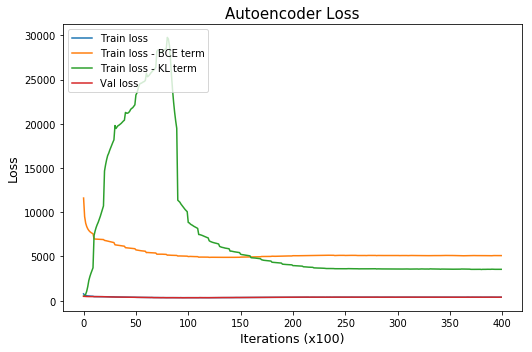

In [12]:
import matplotlib.ticker as ticker

plt.figure(figsize=(7.5,5))
plt.title("Autoencoder Loss",fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Iterations (x100)', fontsize=12.5)
plt.ylabel('Loss', fontsize=12.5)
plt.plot(loss_history, label='Train loss')
plt.plot(bce_loss_history, label='Train loss - BCE term')
plt.plot(kl_loss_history, label='Train loss - KL term')
# plt.plot(acc_history, label='Accuracy')
# print(val_loss_history[:][1])
plt.plot(val_loss_history, label='Val loss')
# plt.plot(val_loss_history[:][1], label='Validation KL loss')
plt.legend(loc='upper left')
plt.tight_layout()

[0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000, 1025, 1050, 1075, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325, 1350, 1375, 1400, 1425, 1450, 1475, 1500, 1525, 1550, 1575, 1600, 1625, 1650, 1675, 1700, 1725, 1750, 1775, 1800, 1825, 1850, 1875, 1900, 1925, 1950, 1975, 2000, 2025, 2050, 2075, 2100, 2125, 2150, 2175, 2200, 2225, 2250, 2275, 2300, 2325, 2350, 2375, 2400, 2425, 2450, 2475, 2500, 2525, 2550, 2575, 2600, 2625, 2650, 2675, 2700, 2725, 2750, 2775, 2800, 2825, 2850, 2875, 2900, 2925, 2950, 2975, 3000, 3025, 3050, 3075, 3100, 3125, 3150, 3175, 3200, 3225, 3250, 3275, 3300, 3325, 3350, 3375, 3400, 3425, 3450, 3475, 3500, 3525, 3550, 3575, 3600, 3625, 3650, 3675, 3700, 3725, 3750, 3775, 3800, 3825, 3850, 3875, 3900, 3925, 3950, 3975, 4000, 4025, 4050, 4075, 4100, 4125, 4150, 4175, 4200, 4225, 4250, 4275, 4300, 4325, 

C:\Users\maxhu\Anaconda3\envs\kinase\lib\site-packages\matplotlib\legend.py:497: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


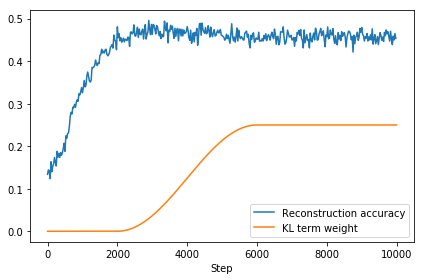

In [13]:
# plt.figure(figsize=(7.5,5))
x_acc = [x*25 for x in range(len(acc_history))]
print(x_acc)
print(len(x_acc), len(acc_history))
kl_w_padded = numpy.hstack((kl_w, numpy.ones(len(acc_history)*25 - len(kl_w))*.25))
plt.plot(x_acc, acc_history, label='Reconstruction accuracy')
plt.plot(kl_w_padded, label='KL term weight')
print(len(acc_history), len(kl_w))
plt.legend(loc='bottom right')
plt.xlabel('Step')
plt.tight_layout()

Train z (mean, std dev): (0.02371632494032383, 1.0196995735168457)


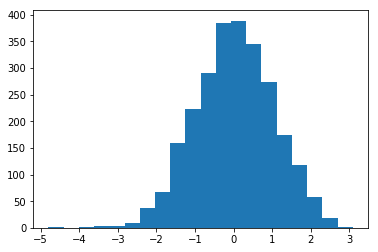

In [14]:
mIdx_batch, maxLen, target_batch, mIdc, label_batch = getBatch(trainIdc)
_, _, _, z = model(mIdx_batch, c=label_batch)
z=z.detach().numpy()
print('Train z (mean, std dev): ({}, {})'.format(numpy.mean(z), numpy.std(z)))
# print(numpy.std(z, axis=1))
# print(numpy.mean(z, axis=1))

z=z.reshape(-1)
# z = z.reshape(-1).detach().numpy()

plt.hist(z, bins=20)
plt.show()

# inference

In [15]:
motifs = (numpy.genfromtxt('data/new/new_motifs.csv',dtype='U',delimiter='µ'))
fams = (numpy.genfromtxt('data/new/new_fams.csv',dtype='U'))
motifxFamMatrix = numpy.genfromtxt('data/new/new_motifxFamMatrix.csv',delimiter=',',dtype=int)
motifsPhosphoHuman = (numpy.genfromtxt('data/motifsPhosphoHuman.csv',dtype='U'))
print(len(motifsPhosphoHuman))

summed = motifxFamMatrix.sum(axis=0)
print(summed.shape, summed, summed[42])

example_category = []
for i in range(motifxFamMatrix.shape[0]):
    if motifxFamMatrix[i, 42] == 1:
        example_category.append(motifs[i])

print(example_category[:20])

215831
(133,) [  37   22   80    0    0   72  510   25   38   64   64    1    4   61
  637  149   43   14   59   77   16    7   35   56   69  134   73   72
   44  170   76    0    0   30   97   14   45   12   71    0  454   29
   89   78   55  104  859   26   95   26  796   13   35  466   16   80
  177   47   68  420   14    0  519   94   44   52    1    0    2  127
   48   87  235   35    0   35  123  294   61  115    0   13   29   93
  237   29   63    0   42  467  351   68   29   91    1   43    3   58
   65  248   19    9  201    0    5  316  173  307 1066    0  146   63
  182  110  677    0   36   17  664  288   84  373   77   96  190 1267
    0    3    0    0   34   11   35] 89
['EGSFESRYQQPFEDF', 'RRPPGLEYCYNPSHN', 'LRQEEAEYVRALFDF', 'RREDKFMYFEFPQPL', 'PPGLEYCYNPSHNPE', 'REESDGEYDEFGRKK', 'PSNHHAVYDVPPSVS', 'SKAQQGLYQVPGPSP', 'AEDAKAIYDFTDTVI', 'AYATEAVYESAEAPG', 'KSAVGFEYQGKTEKH', 'LQPTVRTYVENRPKY', 'KRNSLPQYQATMPDG', 'LEGDFRSYGAADHYG', 'QSAVGFEYQGKTEKH', 'NPLLLNTYNKFPYPT', 'K

In [16]:
# test_model = VAE(LATENT_SIZE)

gen_batch_size = 500
rand_labels = numpy.random.randint(133, size=10)

c = numpy.zeros((gen_batch_size, 133))
for i, label in enumerate(rand_labels):
    c[i, label] = 1

# c[:, 42] = 1

c = torch.tensor(c).float()
# print(c.shape)

gen_strs = model.inference(n=gen_batch_size, c=c)
gen_strs = gen_strs.argmax(dim=2).numpy()
gen_strs = gen_strs.transpose()

gen_strings = []
for motif in gen_strs:
    #     predname = ''.join([amino_acids[char_index] for char_index in motif])
    first_half = ''.join([amino_acids[char_index] for char_index in motif[:7]])
    middle = amino_acids[motif[7]]
    second_half = ''.join([amino_acids[char_index] for char_index in motif[8:]])
    
    gen_strings.append(first_half +middle +second_half)
    # print with middle letter clearly visible
#     print('{} {} {}'.format(first_half, middle, second_half))


# generate random strings
rand_strs = numpy.random.randint(21, size=(gen_batch_size,15))
rand_strings = []
for motif in rand_strs:
    #     predname = ''.join([amino_acids[char_index] for char_index in motif])
    first_half = ''.join([amino_acids[char_index] for char_index in motif[:7]])
    middle = amino_acids[motif[7]]
    second_half = ''.join([amino_acids[char_index] for char_index in motif[8:]])
    
    rand_strings.append(first_half +middle +second_half)
    # print with middle letter clearly visible
#     print('{} {} {}'.format(first_half, middle, second_half))

# should have S, T, or Y in the middle

In [26]:
def hamming_distance(string1, string2): 
    # Start with a distance of zero, and count up
    distance = 0
    # Loop over the indices of the string
    L = len(string1)
    for i in range(L):
        # Add 1 to the distance if these two characters are not equal
        if string1[i] != string2[i]:
            distance += 1
    # Return the final count of differences
    return distance #/ L

def get_min_hams(gen_strings, real_strings):
    min_hams = []
    hams_only = []
    for i, gen_motif in enumerate(gen_strings):
        if i%40 == 0 or i == len(gen_strings)-1:
            print(i, '/', len(gen_strings)-1)
            
        min_ham = numpy.inf
        min_real_motif = None
        min_gen_motif = None

        for j, real_motif in enumerate(real_strings):
            ham = hamming_distance(real_motif, gen_motif)
            if ham < min_ham:
                min_ham = ham
                min_real_motif = real_motif
                min_gen_motif = gen_motif

        min_hams.append([min_gen_motif, min_real_motif, min_ham])
        hams_only.append(min_ham)

    return min_hams, numpy.array(hams_only)

0 / 499
40 / 499
80 / 499
120 / 499
160 / 499
200 / 499
240 / 499
280 / 499
320 / 499
360 / 499
400 / 499
440 / 499
480 / 499
499 / 499
7.386


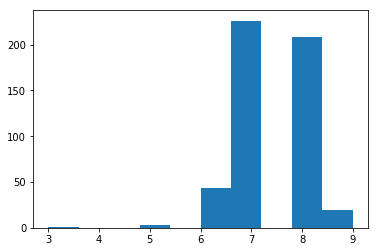

In [27]:
# from scipy.spatial import distance

# print(motifsPhosphoHuman[0])
# print(gen_strings[0])

gen_min_hams, gen_hams_only = get_min_hams(gen_strings, motifsPhosphoHuman)

# a = numpy.array(min_hams)
# a = numpy.array(a[:, 2], dtype=float)
print(numpy.mean(gen_hams_only))
plt.hist(gen_hams_only)
plt.show()

# 128: .48?
# 500: 0.4852

0 / 499
40 / 499
80 / 499
120 / 499
160 / 499
200 / 499
240 / 499
280 / 499
320 / 499
360 / 499
400 / 499
440 / 499
480 / 499
499 / 499
8.792


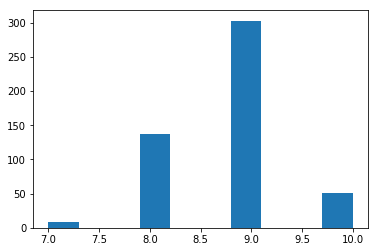

In [30]:
rand_min_hams, rand_hams_only = get_min_hams(rand_strings, motifsPhosphoHuman)
# a = numpy.array(rand_min_hams)
# a = numpy.array(a[:, 2], dtype=float)
print(numpy.mean(rand_hams_only))
plt.hist(rand_hams_only)
plt.show()

# 128: 0.5890624999999998
# 500: 

[3 5 6 7 8 9]
[  1   3  43 226 208  19]
[ 7  8  9 10]
[  9 137 303  51]


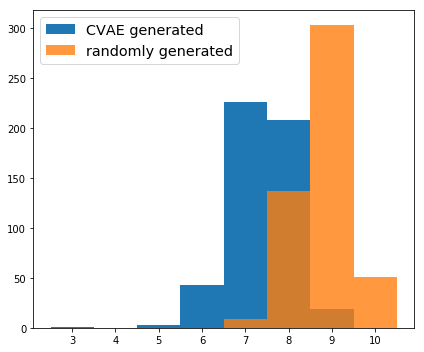

In [82]:
gen_unique_vals, gen_unique_counts = numpy.unique(gen_hams_only, return_counts=True)
print(gen_unique_vals)
print(gen_unique_counts)

rand_unique_vals, rand_unique_counts = numpy.unique(rand_hams_only, return_counts=True)
print(rand_unique_vals)
print(rand_unique_counts)

w = 0.5

# color=matplotlib.colors.to_rgba('C0', 0.5)
c0 = colors.to_rgba('C0', 1.0)
c1 = colors.to_rgba('C1', 0.8)
plt.figure(figsize=(6,5))
plt.bar(gen_unique_vals, gen_unique_counts, width=1.0, color=c0, label='CVAE generated')
plt.bar(rand_unique_vals, rand_unique_counts, width=1.0, color=c1, label='randomly generated')
# plt.bar(gen_unique_vals - w/2, gen_unique_counts, width=w, color='C0', label='CVAE generated')
# plt.bar(rand_unique_vals + w/2, rand_unique_counts, width=w, color='C1', label='randomly generated')
# plt.xlabel('Hamming distance', fontsize='x-large')
# plt.ylabel('Frequency', fontsize='x-large')
# plt.title('Similarity to naturally occurring substrates', fontsize='x-large')
plt.legend(fontsize='x-large')
# plt.savefig('generations_comparison_no_labels_tight.pdf')
plt.tight_layout()
plt.show()

#### plt.hist(gen_hams_only, bins=5, label='CVAE generated')
plt.hist(rand_hams_only, bins=4, label='randomly generated')
plt.xlabel('Hamming distance')
plt.ylabel('Frequency')
plt.title('Similarity to real substrates')
plt.legend()
plt.show()

In [182]:
# let's look at some of the best ones

# get ids of the smallest 10 ham distances
gen_ids = gen_hams_only.argsort()[:10]

for i in gen_ids:
    print(gen_min_hams[i])
    
print(1- 10/15) # 10/15 correct

['RSTEERRTSDESPKS', 'RSSLSRRSSMESPKS', 0.3333333333333333]
['SRSGSTRSPDESRES', 'SRSGSTRSRSYSRSF', 0.3333333333333333]
['TEEESPPSSESTSLS', 'TYLESPLSSETTQLS', 0.3333333333333333]
['SKPSKSTSSSRTSSP', 'SSPSSSSSSSSSSSP', 0.3333333333333333]
['SPSDTQGSTTATPAP', 'TPSSTTSSTRATPAP', 0.3333333333333333]
['RTATPASSADGGLRE', 'STASPTSSVDGGLGA', 0.4]
['KPRSTPESGGLRKPT', 'EPRSTPESGDSDKES', 0.4]
['SPRRPLDSELPTRPS', 'SKRKPAMSPLLTRPS', 0.4]
['STKLPKTEDLSAPPS', 'RTDLQKVSDLSAPFS', 0.4]
['PRRLLPASSQPSGPS', 'DQRLRKASDQPSGHS', 0.4]
0.33333333333333337


In [180]:
# get ids of the smallest 10 ham distances
rand_ids = rand_hams_only.argsort()[:10]

for i in rand_ids:
    print(rand_min_hams[i])

print(1- 8/15) # 8/15 correct

['TCTCQCSHD_NGYAH', 'TPTCQSSTDCSPYAR', 0.4666666666666667]
['_PYMGRKSVHWPESK', 'SSYRGRKSGNKPPSK', 0.4666666666666667]
['WVSSWEHDMNTHTES', 'WQSSIVHYMNRMTQS', 0.4666666666666667]
['NDHFVSPTKALLSVI', 'RGPRASPTKALLSTP', 0.4666666666666667]
['RSPYFVTHVAKVEGT', 'RSPQPVCSPAGSEGT', 0.4666666666666667]
['_HSAPDNIMSRSQKY', 'TQSNPDHSSSRSQKS', 0.4666666666666667]
['YLSSRTTRPQNST_N', 'PLGSRSQTPSPSTLN', 0.5333333333333333]
['ALIAPNYSIRRFWDR', 'ALLADITSKYRQGDR', 0.5333333333333333]
['_TDNWSM_EKFVQLL', 'NVSGGSMTEMFVQLK', 0.5333333333333333]
['ETWETFSFAQQNIWY', 'EAGETFSSVQANLSK', 0.5333333333333333]
0.4666666666666667


In [153]:
# generate some for some specific classes
# classes: 114, 66, 26
class_id = 26
sample_size = 400

c = numpy.zeros((sample_size, 133))
c[:, class_id] = 1
c = torch.tensor(c).float()

gen_strs = model.inference(n=sample_size, c=c)
gen_strs = gen_strs.argmax(dim=2).numpy()
gen_strs = gen_strs.transpose()

gen_strings = []
for motif in gen_strs:
    #     predname = ''.join([amino_acids[char_index] for char_index in motif])
    first_half = ''.join([amino_acids[char_index] for char_index in motif[:7]])
    middle = amino_acids[motif[7]]
    second_half = ''.join([amino_acids[char_index] for char_index in motif[8:]])
    
    gen_strings.append(first_half +middle +second_half)
    # print with middle letter clearly visible
#     print('{} {} {}'.format(first_half, middle, second_half))

# print(gen_strings)
numpy.savetxt('{}.txt'.format(class_id), gen_strings, fmt="%s")

# kl annealing

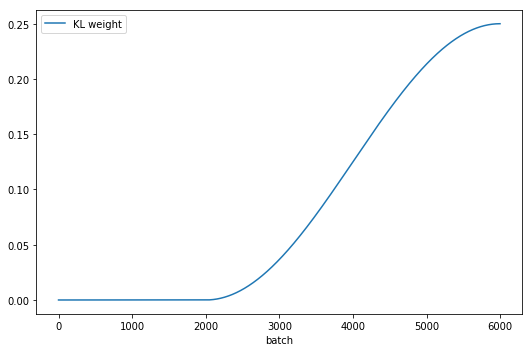

In [86]:
plt.figure(figsize=(7.5,5))
plt.plot(kl_w, label='KL weight')
plt.legend(loc='upper left')
plt.xlabel('batch')
plt.tight_layout()